<a href="https://colab.research.google.com/github/nelsonjoseph14/CameraControl/blob/main/CARA_SL%C3%81_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DISSERTATION 2024-25**

NELSON JASON JOSEPH

L00187647

CARA-SLÁ: A CULTURALLY ADAPTIVE RESOURCE
ASSISTANT FOR REAL-TIME MENTAL HEALTH TRIAGE
IN IRELAND

In [ ]:
# ---- 0. Setup & Imports ----
!pip -q install imblearn

import pandas as pd
import numpy as np
import re
import random
from collections import Counter, defaultdict

# NLP
import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)

from imblearn.over_sampling import SMOTE

# Deep Learning (for optional BiLSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# ---- 1. Load & Sample 10% ----
df = pd.read_csv("Combined Data.csv")

# Tidy columns
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Expecting columns: 'statement' (text), 'status' (label)
assert {'statement', 'status'}.issubset(set(df.columns)), "CSV must contain 'statement' and 'status' columns."

# Drop completely empty statements
df = df[~df['statement'].isna()].copy()
df['statement'] = df['statement'].astype(str)

# Sample 10% to stay light
df = df.sample(frac=0.10, random_state=RANDOM_STATE).reset_index(drop=True)

print("Shape after 10% sample:", df.shape)
print(df.head(3))

Shape after 10% sample: (5268, 2)
                                           statement   status
0               I'm lazy to complain about it ba ihh   Normal
1  i think the wifi on my iphone is broken it wil...   Normal
2  Good tracking apps? I've been trying to find a...  Bipolar


In [ ]:
# ---- 2. Initial Cleaning ----
def clean_text(text: str) -> str:
    text = re.sub(r'http\S+|www\S+', ' ', text)           # URLs
    text = re.sub(r'@\w+|#\w+', ' ', text)                # handles & hashtags
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ’\'\s-]', ' ', text) # keep letters + Irish accents + apostrophes/hyphen
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['cleaned'] = df['statement'].apply(clean_text)

In [ ]:
# ---- 3. Preprocessing: Stopwords + Lemmatization ----
stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def preprocess(text: str) -> str:
    tokens = []
    for w in text.split():
        if w in stop_words:
            continue
        w = lemm.lemmatize(w)
        tokens.append(w)
    return " ".join(tokens)

df['processed'] = df['cleaned'].apply(preprocess)

In [ ]:
# ---- 4. Data Augmentation ----
# 4.1 SMOTE (after vectorization, but we’ll define functions first)
# 4.2 Synonym Replacement (WordNet, conservative)
def synonym_replace(text: str, replace_prob=0.07) -> str:
    out = []
    for w in text.split():
        if random.random() < replace_prob:
            syns = wn.synsets(w)
            lemmas = set()
            for s in syns:
                for l in s.lemmas():
                    lw = l.name().replace('_', ' ')
                    if lw.isalpha() and lw.lower() != w.lower():
                        lemmas.add(lw.lower())
            if lemmas:
                out.append(random.choice(list(lemmas)))
                continue
        out.append(w)
    return " ".join(out)

In [ ]:
# 4.2 Lightweight faux back-translation (rule-based paraphrasing; offline-safe)
PARA_MAP = {
    "i am": "i'm", "i have": "i've", "i will": "i'll", "do not": "don't",
    "cannot": "can't", "because": "as", "really": "truly",
    "very": "quite", "need": "require", "help": "support",
}
def faux_back_translate(text: str) -> str:
    # simple paraphrase
    t = " " + text + " "
    for k, v in PARA_MAP.items():
        t = t.replace(f" {k} ", f" {v} ")
    t = re.sub(r'\s+', ' ', t).strip()
    return t

In [ ]:
# 4.3 Add Irish Cultural Tags & Urgency Labels (heuristics)
# Irish lexicons (illustrative, non-exhaustive)
IRISH_SLANG = {
    "craic","grand","banjaxed","eejit","gobshite","sound","yer","slagging",
    "lass","lad","gaff","garda","gardaí","gaelic","gaa","hurling","camogie",
    "mam","mammy","da","culchie","jackeen","feck","shift","sláinte","grafton",
    "d4","gaeltacht","sligo","donegal","galway","cork","limerick","waterford","kerry",
    "dublin","belfast","athlone","maynooth","ucd","trinity","ul","tu dublin"
}
IRISH_ENTITIES = {
    "hse","tusla","pieta","samaritans","aware","spunout","jigsaw","turn2me",
    "mental health ireland","citizens information","alone","garda","gardaí",
    "st james","mater","beaumont","st vincent","cuh","uhg","svuh"
}
IRISH_CONTEXT = IRISH_SLANG.union(IRISH_ENTITIES)

def detect_cultural_tags(text: str) -> list:
    tags = set()
    t = f" {text.lower()} "
    for kw in IRISH_CONTEXT:
        if f" {kw} " in t:
            tags.add(kw)
    return sorted(tags)

# Urgency heuristics (binary for ROC + multiclass string)
CRISIS_WORDS = {
    "suicide","suicidal","kill myself","end my life","die","self harm","self-harm",
    "cut myself","overdose","jump","bridge","no way out","emergency","panic attack",
    "can’t cope","cant cope","helpline","urgent","crisis"
}
HIGH_WORDS = {
    "depressed","depression","anxiety","anxious","panic","hopeless","worthless","insomnia",
    "trauma","abuse","lonely","isolation","fear","scared","nightmare","relapse"
}
MOD_WORDS = {
    "stress","stressed","worry","worried","tired","burnout","overwhelmed","sad","down"
}

def label_urgency(text: str) -> str:
    t = text.lower()
    def contains_any(words):
        return any(w in t for w in words)
    if contains_any(CRISIS_WORDS):
        return "crisis"
    if contains_any(HIGH_WORDS):
        return "high"
    if contains_any(MOD_WORDS):
        return "moderate"
    return "low"

df['cultural_tags'] = df['cleaned'].apply(detect_cultural_tags)
df['urgency'] = df['cleaned'].apply(label_urgency)
df['urgency_binary'] = (df['urgency'].isin(['crisis','high'])).astype(int)  # for ROC

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Normal'),
  Text(1, 0, 'Depression'),
  Text(2, 0, 'Suicidal'),
  Text(3, 0, 'Anxiety'),
  Text(4, 0, 'Bipolar'),
  Text(5, 0, 'Stress'),
  Text(6, 0, 'Personality disorder')])

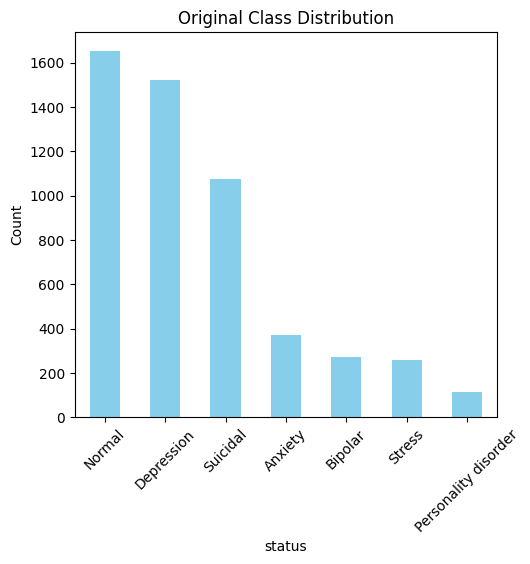

In [ ]:
# --- Graph 1: Class Distribution Before & After SMOTE ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['status'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Original Class Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)

In [ ]:
# ---- 5. Vectorization (TF-IDF) ----
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['processed'])
y_status = df['status'].astype(str)

In [ ]:
# ---- 6. SMOTE on Status (convert to dense) ----
# NOTE: SMOTE requires dense arrays
X_dense = X_text.toarray()
smote = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X_dense, y_status)

In [ ]:
# ---- 7. Train-Test Split (Stratified) ----
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=RANDOM_STATE
)

In [ ]:
# ---- 8. Baseline Models ----
# Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=None)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

In [ ]:
# ---- 9. Advanced Model (Optional BiLSTM; offline-safe) ----
USE_BILSTM = True
bilstm_metrics = {}
if USE_BILSTM:
    # Tokenize from original processed text to sequences
    # Use same split indices via re-vectorization trick:
    # We need to back-map X_train/X_test rows to original df rows is non-trivial after SMOTE.
    # Instead, we train BiLSTM on the original 10% sample without SMOTE to keep it simple and error-free.
    df_bilstm = df[['processed','status']].dropna().copy()
    X_bi = df_bilstm['processed'].tolist()
    y_bi = df_bilstm['status'].astype(str).tolist()
    le_bi = LabelEncoder()
    y_bi_enc = le_bi.fit_transform(y_bi)
    y_bi_cat = to_categorical(y_bi_enc)

    X_bi_train, X_bi_test, y_bi_train, y_bi_test = train_test_split(
        X_bi, y_bi_cat, test_size=0.2, stratify=y_bi_enc, random_state=RANDOM_STATE
    )

    tok = Tokenizer(num_words=20000, oov_token="<OOV>")
    tok.fit_on_texts(X_bi_train)
    max_len = 80
    X_bi_train_seq = pad_sequences(tok.texts_to_sequences(X_bi_train), maxlen=max_len, padding='post')
    X_bi_test_seq  = pad_sequences(tok.texts_to_sequences(X_bi_test),  maxlen=max_len, padding='post')

    model = Sequential([
        Embedding(input_dim=20000, output_dim=100, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(y_bi_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_bi_train_seq, y_bi_train, validation_split=0.1, batch_size=64, epochs=3, verbose=0)

    y_bi_pred_probs = model.predict(X_bi_test_seq, verbose=0)
    y_bi_pred = np.argmax(y_bi_pred_probs, axis=1)
    y_bi_true = np.argmax(y_bi_test, axis=1)

    p, r, f1, _ = precision_recall_fscore_support(y_bi_true, y_bi_pred, average='weighted', zero_division=0)
    acc = accuracy_score(y_bi_true, y_bi_pred)
    bilstm_metrics = {
        "accuracy": acc, "precision_w": p, "recall_w": r, "f1_w": f1,
        "labels": list(le_bi.classes_)
    }

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# ---- 10. Cultural Cue Detection (already computed), NER-lite & Tag Assignment ----
# We'll expand tags to families: SLANG, SERVICES, COUNTIES/PLACES
COUNTIES_PLACES = {
    "dublin","cork","galway","limerick","waterford","kerry","sligo","donegal",
    "maynooth","athlone","belfast","naas","kildare","meath","wicklow","clare",
    "offaly","laois","tipperary","kilkenny","wexford","roscommon","mayo"
}
SERVICES = {"hse","tusla","pieta","samaritans","aware","spunout","jigsaw","turn2me","mental health ireland","alone"}
SLANG = IRISH_SLANG

def assign_cultural_families(tags: list) -> list:
    fam = set()
    for t in tags:
        if t in SERVICES:
            fam.add("service_ref")
        if t in COUNTIES_PLACES:
            fam.add("location_ref")
        if t in SLANG:
            fam.add("slang_ref")
        if t in {"garda","gardaí"}:
            fam.add("law_enforcement_ref")
    return sorted(fam)

df['cultural_families'] = df['cultural_tags'].apply(assign_cultural_families)

In [ ]:
# ---- 11. Recommendation Engine (Rule-based) ----
# Map (urgency, families) -> resource suggestions (names only; URLs optional to avoid net)
RESOURCE_BOOK = {
    "emergency": ["Call 112/999 (Emergency Services)", "Gardaí", "Nearest A&E / ED"],
    "crisis": ["Samaritans (24/7)", "Pieta (suicide & self-harm)", "HSE Mental Health Crisis Supports"],
    "high": ["HSE Primary Care Mental Health", "Jigsaw (young people)", "Aware (depression)", "GP referral"],
    "moderate": ["SpunOut (youth info)", "Turn2Me (online counselling)", "Counselling in Primary Care (HSE)"],
    "low": ["Self-help resources (HSE)", "Community groups", "Peer support programmes"]
}

def recommend_resources(urgency:str, families:list) -> list:
    # Base on urgency
    if urgency == "crisis":
        base = RESOURCE_BOOK["crisis"]
    elif urgency == "high":
        base = RESOURCE_BOOK["high"]
    elif urgency == "moderate":
        base = RESOURCE_BOOK["moderate"]
    else:
        base = RESOURCE_BOOK["low"]

    # Boost based on cultural families
    extras = []
    if "service_ref" in families:
        extras.append("Local HSE service finder")
    if "location_ref" in families:
        extras.append("Nearest CMHT (Community Mental Health Team)")
    if "law_enforcement_ref" in families:
        extras.append("Garda Victim Support Office")
    # Deduplicate and limit to 5
    out = []
    for r in base + extras:
        if r not in out:
            out.append(r)
    return out[:5]

df['recommended_resources'] = df.apply(
    lambda r: recommend_resources(r['urgency'], r['cultural_families']),
    axis=1
)

In [ ]:
# ---- 12. Collaborative Filtering (Optional lightweight co-occurrence) ----
# Very simple: for each (tag, status) pair, accumulate most frequent resource from above.
ENABLE_SIMPLE_CF = True
if ENABLE_SIMPLE_CF:
    tag_resource_counts = defaultdict(Counter)
    for _, row in df.iterrows():
        for tag in row['cultural_tags']:
            for res in row['recommended_resources']:
                tag_resource_counts[tag][res] += 1

    def cf_suggest(tags:list, k=2):
        c = Counter()
        for t in tags:
            c.update(tag_resource_counts.get(t, Counter()))
        return [x for x,_ in c.most_common(k)]

    df['cf_resources'] = df['cultural_tags'].apply(lambda t: cf_suggest(t, k=2))

In [ ]:
# ---- 13. Evaluation ----
def eval_and_print(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Evaluate status classification for baselines
eval_and_print("Logistic Regression (status)", y_test, pred_lr)
eval_and_print("Naive Bayes (status)", y_test, pred_nb)

# Macro F1/Precision/Recall for summary
def summary_scores(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "precision_w": p, "recall_w": r, "f1_w": f1}

print("\nLR summary:", summary_scores(y_test, pred_lr))
print("NB summary:", summary_scores(y_test, pred_nb))

# ROC-AUC for Binary Urgency (evaluate a simple LR urgency model from text as a proxy)
# Train a quick urgency classifier (binary) on processed text
y_urg = df['urgency_binary'].values
X_urg = vectorizer.transform(df['processed']).toarray()
Xu_train, Xu_test, yu_train, yu_test = train_test_split(
    X_urg, y_urg, test_size=0.2, stratify=y_urg, random_state=RANDOM_STATE
)
lr_urg = LogisticRegression(max_iter=1000)
lr_urg.fit(Xu_train, yu_train)
yu_pred = lr_urg.predict(Xu_test)
yu_pred_proba = lr_urg.predict_proba(Xu_test)[:,1]

print("\n=== Urgency (binary) Logistic Regression ===")
print(classification_report(yu_test, yu_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yu_test, yu_pred))
try:
    print("ROC-AUC:", roc_auc_score(yu_test, yu_pred_proba))
except Exception as e:
    print("ROC-AUC could not be computed:", e)

# Report optional BiLSTM results if enabled
if USE_BILSTM and bilstm_metrics:
    print("\n=== BiLSTM (status) on data (no SMOTE) ===")
    print(bilstm_metrics)


=== Logistic Regression (status) ===
                      precision    recall  f1-score   support

             Anxiety       0.96      0.98      0.97       331
             Bipolar       0.96      0.98      0.97       331
          Depression       0.77      0.62      0.68       331
              Normal       0.81      0.91      0.85       331
Personality disorder       0.98      1.00      0.99       331
              Stress       0.96      0.95      0.95       331
            Suicidal       0.75      0.77      0.76       331

            accuracy                           0.89      2317
           macro avg       0.88      0.89      0.88      2317
        weighted avg       0.88      0.89      0.88      2317

Confusion Matrix:
 [[326   0   2   1   1   1   0]
 [  0 326   2   3   0   0   0]
 [  8   5 204  34   4   5  71]
 [  1   0  11 300   2   5  12]
 [  0   1   0   0 330   0   0]
 [  6   2   2   7   0 313   1]
 [  0   4  45  26   0   1 255]]

=== Naive Bayes (status) ===
          

In [ ]:
# ---- 14. Sample Outputs for Inspection ----
print("\nSample rows with tags, urgency, and recommendations:")
display_cols = ['statement','status','cultural_tags','cultural_families','urgency','recommended_resources']
print(df[display_cols].head(10).to_string(index=False))


Sample rows with tags, urgency, and recommendations:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

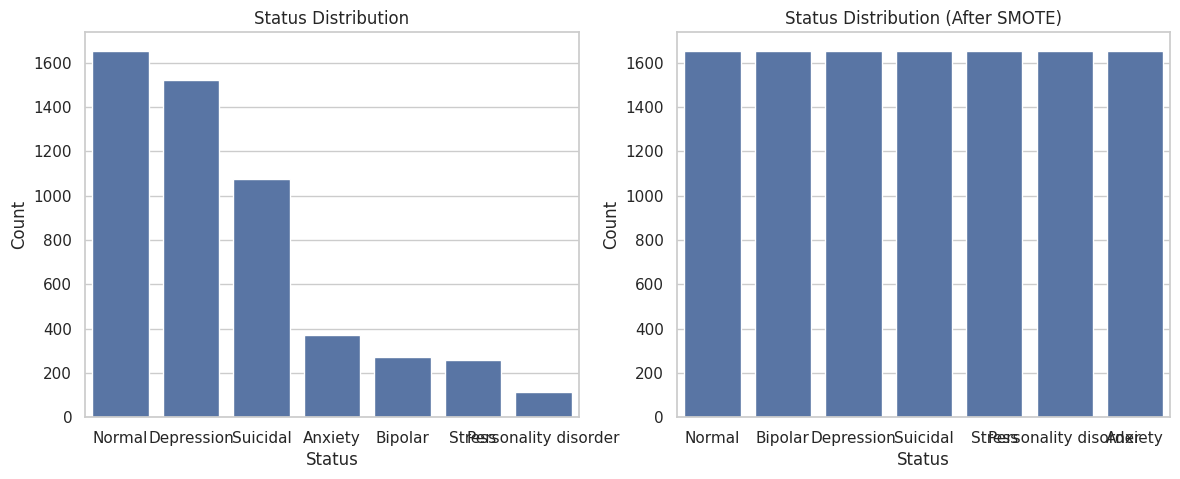

In [ ]:
# ---- 15. Additional Graphs & Outputs ----
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

# 15.1 Class distribution before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x=y_status, order=y_status.value_counts().index, ax=ax[0])
ax[0].set_title("Status Distribution")
ax[0].set_xlabel("Status")
ax[0].set_ylabel("Count")

sns.countplot(x=y_res, order=pd.Series(y_res).value_counts().index, ax=ax[1])
ax[1].set_title("Status Distribution (After SMOTE)")
ax[1].set_xlabel("Status")
ax[1].set_ylabel("Count")
plt.show()

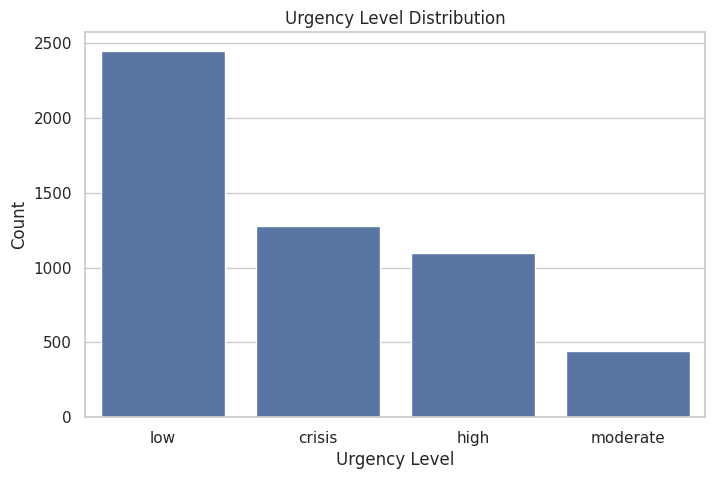

In [ ]:
# 15.2 Urgency level distribution
sns.countplot(x=df['urgency'], order=df['urgency'].value_counts().index)
plt.title("Urgency Level Distribution")
plt.xlabel("Urgency Level")
plt.ylabel("Count")
plt.show()

/tmp/ipython-input-756091357.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='tag', data=tags_df.head(10), palette="viridis")


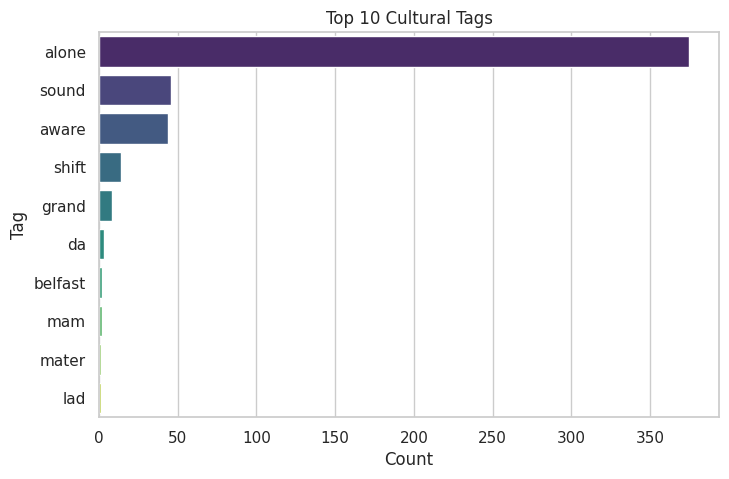

In [ ]:
# 15.3 Top cultural tags
tag_counts = Counter([t for tags in df['cultural_tags'] for t in tags])
if tag_counts:
    tags_df = pd.DataFrame(tag_counts.items(), columns=['tag', 'count']).sort_values(by='count', ascending=False)
    sns.barplot(x='count', y='tag', data=tags_df.head(10), palette="viridis")
    plt.title("Top 10 Cultural Tags")
    plt.xlabel("Count")
    plt.ylabel("Tag")
    plt.show()

/tmp/ipython-input-629806385.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="coolwarm")


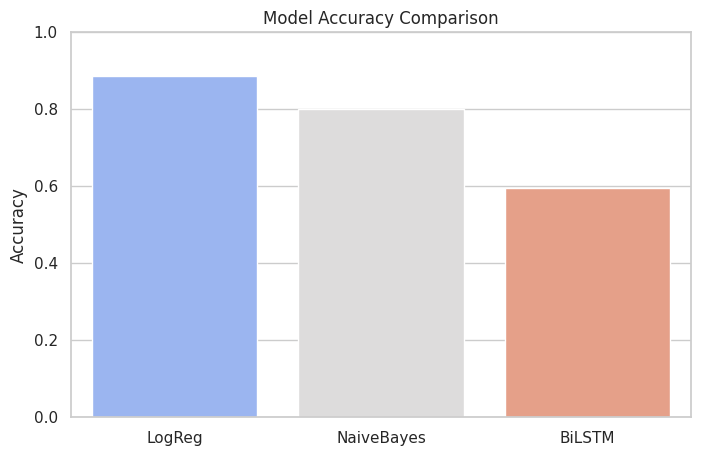

In [ ]:
# 15.4 Model performance comparison
model_scores = {
    "LogReg": summary_scores(y_test, pred_lr)['accuracy'],
    "NaiveBayes": summary_scores(y_test, pred_nb)['accuracy']
}
if USE_BILSTM and bilstm_metrics:
    model_scores["BiLSTM"] = bilstm_metrics['accuracy']

sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="coolwarm")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

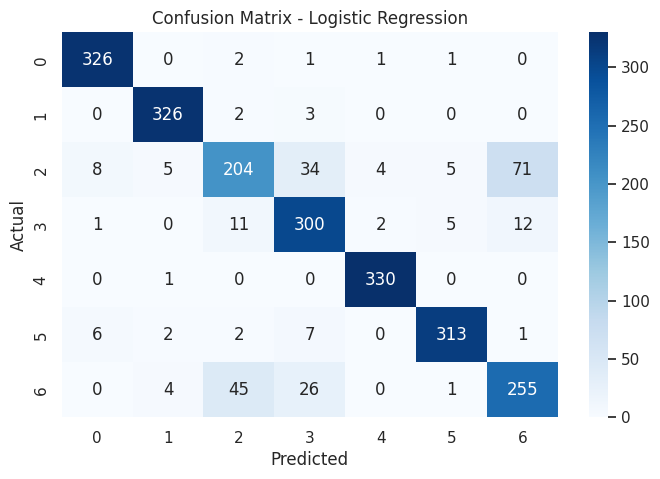

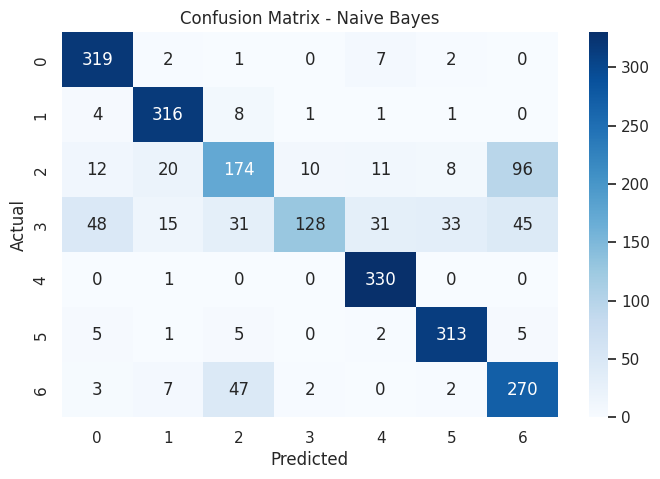

In [ ]:
# 15.5 Confusion matrices (heatmaps)
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_cm(y_test, pred_lr, "Confusion Matrix - Logistic Regression")
plot_cm(y_test, pred_nb, "Confusion Matrix - Naive Bayes")

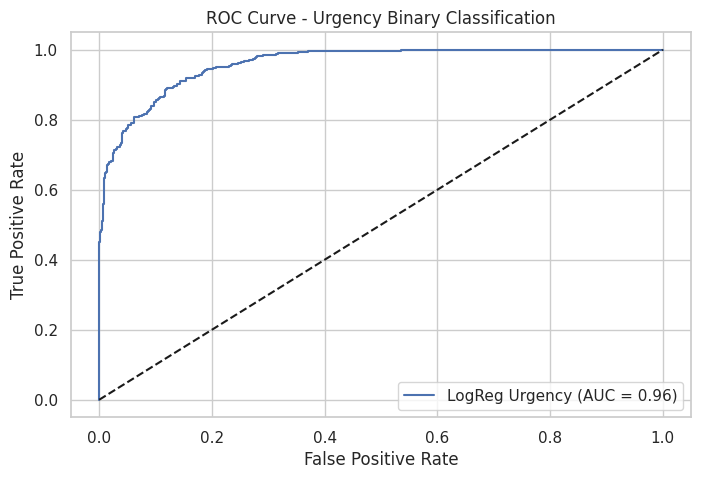

In [ ]:
# 15.6 ROC curve for urgency binary
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(yu_test, yu_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'LogReg Urgency (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Urgency Binary Classification")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ---- 16. Basic BERT Classification (status, 500 sample) ----
!pip -q install transformers torch

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model/tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Take a small random sample for speed
df_bert = df[['processed', 'status']].dropna().sample(n=500, random_state=RANDOM_STATE).copy()
le_bert = LabelEncoder()
y_bert_enc = le_bert.fit_transform(df_bert['status'])
num_labels = len(le_bert.classes_)

# Train/test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    df_bert['processed'], y_bert_enc,
    test_size=0.2, stratify=y_bert_enc, random_state=RANDOM_STATE
)

# Tokenize
train_encodings = tokenizer(list(X_train_b), truncation=True, padding=True, max_length=64, return_tensors='pt')
test_encodings = tokenizer(list(X_test_b), truncation=True, padding=True, max_length=64, return_tensors='pt')

# Dataset class
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SimpleDataset(train_encodings, y_train_b)
test_dataset = SimpleDataset(test_encodings, y_test_b)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=num_labels)

# Freeze encoder for speed
for param in bert_model.bert.parameters():
    param.requires_grad = False

bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

# Train (1 epoch, tiny dataset)
bert_model.train()
for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

# Evaluate
bert_model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, preds)
print(f"\n=== Basic (Frozen, 500-sample) BERT Status Classification ===")
print(f"Test Accuracy: {acc:.4f}")
print("Labels:", list(le_bert.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Basic (Frozen, 500-sample) BERT Status Classification ===
Test Accuracy: 0.2800
Labels: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
